In [1]:
import matplotlib.pyplot as plt
import mcmc.image as im
import mcmc.plotting as p
import numpy as np
import scipy.linalg as sla
import scipy.special as ssp
import mcmc.util_2D as u2

In [2]:
f = im.FourierAnalysis_2D(32,64,-0.5,0.5)

In [3]:
rg = im.RandomGenerator_2D(f.basis_number)

In [4]:
#add regulising
sigma_u = 5e6
sigma_v = 1e2
kappa = 1e17
d = 2
nu = 2 - d/2
alpha = nu + d/2
beta_u = (sigma_u**2)*(2**d * np.pi**(d/2) * ssp.gamma(alpha))/ssp.gamma(nu)
beta_v = beta_u*(sigma_v/sigma_u)**2
sqrtBeta_v = np.sqrt(beta_v)
sqrtBeta_0 = np.sqrt(beta_u)
LuReal = (1/sqrtBeta_0)*(f.Dmatrix*kappa**(-nu) - kappa**(2-nu)*f.Imatrix)
Lu = LuReal + 1j*np.zeros(LuReal.shape)
        
uStdev = -1/np.diag(Lu)
# uStdev = uStdev[self.fourier.basis_number-1:]
# uStdev[0] /= 2 #scaled
n_layers = 2

In [5]:
measurement = im.TwoDMeasurement('shepp.png',target_size=f.extended_basis_number,stdev=0.25,relative_location='phantom_images')

In [6]:
pcn = im.pCN(n_layers,rg,measurement,f,1,'dunlop')

In [7]:
v,res,rank,s = sla.lstsq(pcn.H,pcn.y,lapack_driver='gelsy')

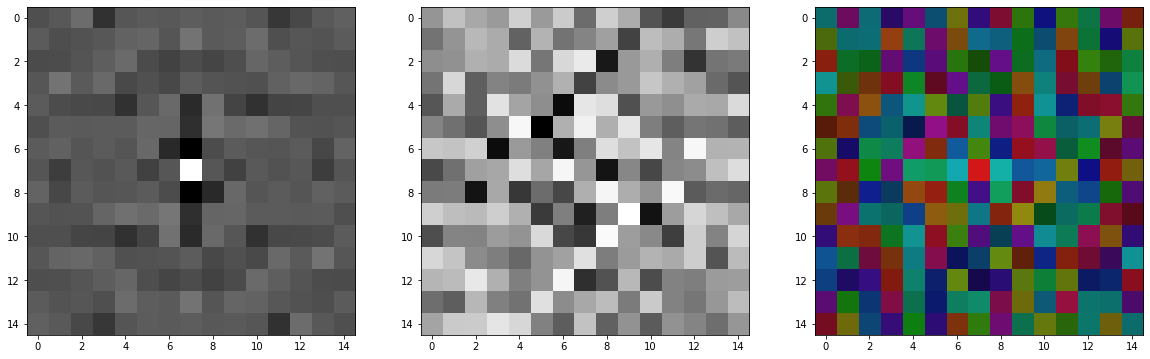

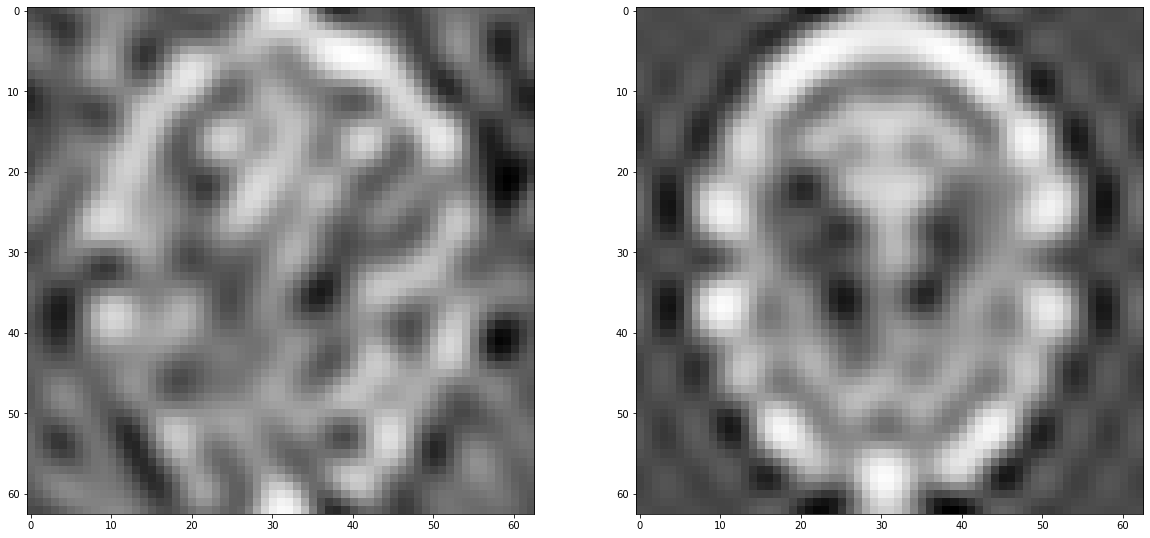

In [8]:
vForiginalHalf = f.fourierTransformHalf(measurement.target_image)
vF = v.reshape(2*f.basis_number-1,2*f.basis_number-1,order=im.ORDER)
#%%

fig, ax = plt.subplots(ncols=3,figsize=(20,20))
ax[0].imshow(vF.real,cmap=plt.cm.Greys_r)
ax[1].imshow(vF.imag,cmap=plt.cm.Greys_r)
ax[2].imshow(p.colorize(vF))
#%%
reconstructed_image = f.inverseFourierLimited(vF[:,f.basis_number-1:]).T
reconstructed_image2 = f.inverseFourierLimited(vForiginalHalf)
scale = np.max(reconstructed_image2-np.min(reconstructed_image2))/np.max(reconstructed_image-np.min(reconstructed_image))
reconstructed_image = reconstructed_image*scale
#%%
fig, ax = plt.subplots(ncols=2,figsize=(20,20))
ax[0].imshow(reconstructed_image,cmap=plt.cm.Greys_r)
ax[1].imshow(reconstructed_image2,cmap=plt.cm.Greys_r)
plt.show()

In [7]:
n_samples = 100
pcn.record_skip = np.max([1, n_samples// pcn.max_record_history])
history_length = np.min([ n_samples, pcn.max_record_history]) 
pcn.sqrtBetas_history = np.empty((history_length,  n_layers), dtype=np.float64)

In [11]:
temp = np.linalg.solve(Lu,rg.construct_w_2D_ravelled())
init_sample_2D_sym = u2.from_u_2D_ravel_to_u_2D(temp,f.basis_number)
init_sample_2D_half = u2.from_u_2D_ravel_to_uHalf_2D(temp,f.basis_number)
for i in range( n_layers):
    if i==0:
        init_sample_sym = np.linalg.solve(Lu,rg.construct_w_2D_ravelled())
        lay = layer.Layer(True, sqrtBeta_0,i, n_samples, pcn,init_sample)
        lay.LMat.current_L = Lu
        lay.LMat.latest_computed_L = Lu
        lay.stdev_sym = uStdev
        lay.stdev = uStdev[ fourier.basis_number-1:]
    else:
        if i == n_layers-1:
            lay = layer.Layer(False, sqrtBeta_v,i, n_samples, pcn,Layers[i-1].current_sample)
            wNew =  pcn.random_gen.construct_w_2D_ravelled()
            eNew = np.random.randn( pcn.measurement.num_sample)
            wBar = np.concatenate((eNew,wNew))
            LBar = np.vstack(( pcn.H,lay.LMat.current_L))
            lay.current_sample_sym, res, rnk, s = np.linalg.lstsq(LBar, pcn.yBar-wBar,rcond=-1)#,rcond=None)
            lay.current_sample = lay.current_sample_sym[ pcn.fourier.basis_number-1:]
        else:
            # lay = layer.Layer(False, sqrtBeta_v*np.sqrt(sigma_scaling),i, n_samples, pcn,Layers[i-1].current_sample)
            lay = layer.Layer(False, sqrtBeta_v*sigma_scaling,i, n_samples, pcn,Layers[i-1].current_sample)

    lay.update_current_sample()
     pcn.Layers_sqrtBetas[i] = lay.sqrt_beta
    # if  pcn_variant:
    #      pcn.record_skip = np.max([1,(lay.n_samples* n_layers)// pcn.max_record_history])
    #     history_length = np.min([lay.n_samples*( n_layers), pcn.max_record_history]) 
    # else:

    lay.samples_history = np.empty((history_length,  fourier.basis_number), dtype=np.complex128)
    Layers.append(lay)

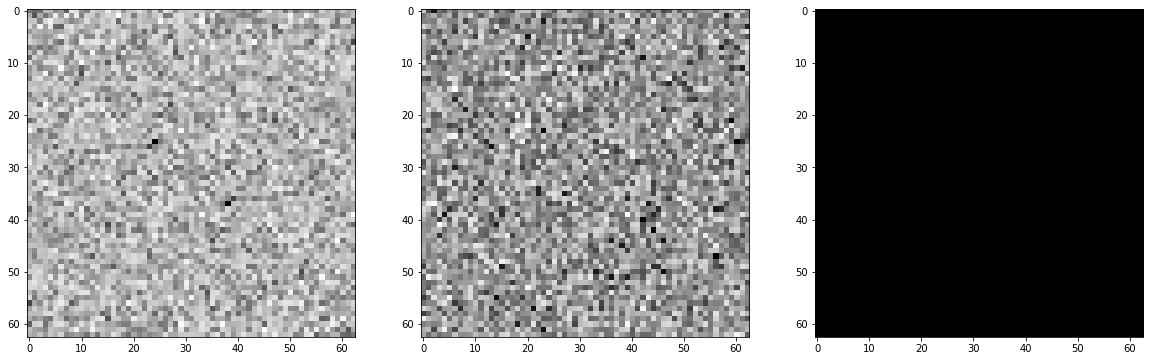

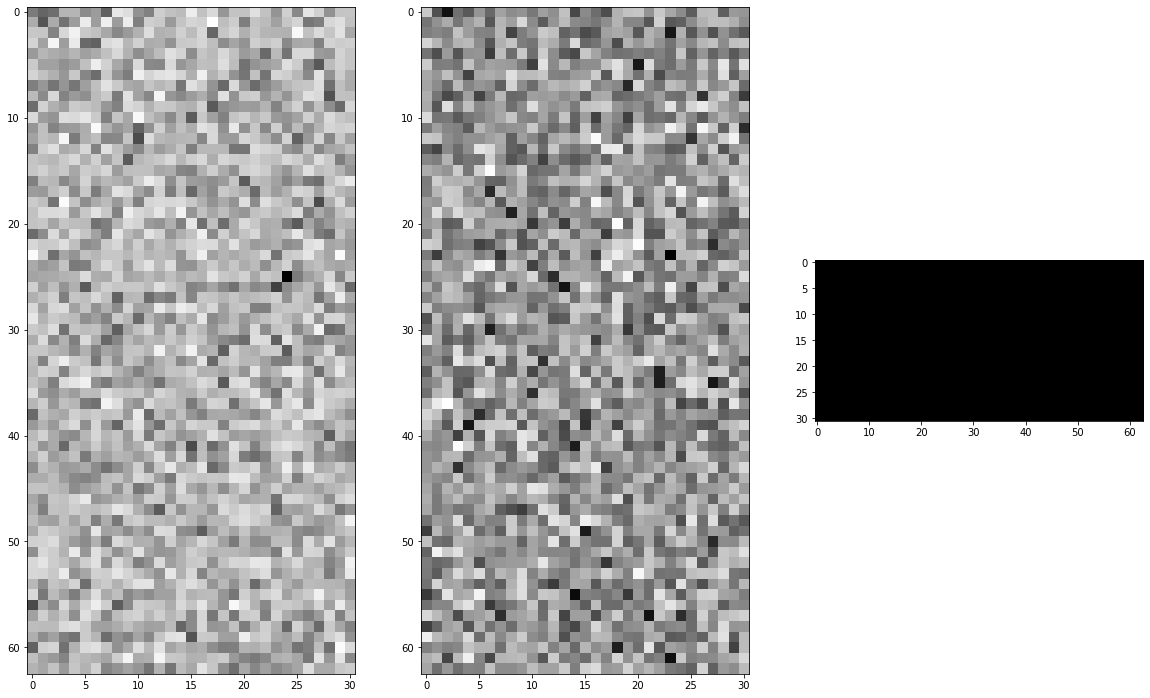

In [13]:
fig, ax = plt.subplots(ncols=3,figsize=(20,20))
ax[0].imshow(init_sample_2D_sym.real,cmap=plt.cm.Greys_r)
ax[1].imshow(init_sample_2D_sym.imag,cmap=plt.cm.Greys_r)
ax[2].imshow(p.colorize(init_sample_2D_sym))
fig, ax = plt.subplots(ncols=3,figsize=(20,20))
ax[0].imshow(init_sample_2D_half.real,cmap=plt.cm.Greys_r)
ax[1].imshow(init_sample_2D_half.imag,cmap=plt.cm.Greys_r)
ax[2].imshow(p.colorize(init_sample_2D_half))

In [3]:
ix,iy = f.Index

In [4]:
ix

array([[ 62,  61,  60, ...,   2,   1,   0],
       [ 63,  62,  61, ...,   3,   2,   1],
       [ 64,  63,  62, ...,   4,   3,   2],
       ...,
       [122, 121, 120, ...,  62,  61,  60],
       [123, 122, 121, ...,  63,  62,  61],
       [124, 123, 122, ...,  64,  63,  62]])

In [5]:
f.ix

array([[-31, -30, -29, ...,  29,  30,  31],
       [-31, -30, -29, ...,  29,  30,  31],
       [-31, -30, -29, ...,  29,  30,  31],
       ...,
       [-31, -30, -29, ...,  29,  30,  31],
       [-31, -30, -29, ...,  29,  30,  31],
       [-31, -30, -29, ...,  29,  30,  31]])